In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
from matplotlib import colormaps
import scipy
import scipy.stats as stats
import matplotlib.ticker as ticker
import json
import anndata as ad
from scipy.sparse import hstack
from moscot.problems.time import TemporalProblem
import cellrank as cr
import scanpy as sc
from cellrank.kernels import RealTimeKernel
import petsc4py
import re
from cellrank.kernels import CytoTRACEKernel
import palantir

In [2]:
adata = sc.read_h5ad("/vol/ExtraVol/DataHistory/Ontogeny_Clustered.h5ad")
# Update the identity annotation
adata.obs.loc[adata.obs["identity"] == "PdgfraloCD55+ FB", "identity"] = "PdgfraloCd55+ FB"
adata.obs_names = adata.obs["CellName"]
adata.obs_names

Index(['AAACCCAAGTATCTGC-1_1', 'AAACCCACATGACTGT-1_1', 'AAAGGATTCCAAACCA-1_1',
       'AAAGGGCAGTCTACCA-1_1', 'AAAGGTACACCACATA-1_1', 'AAAGTCCAGGTGGCTA-1_1',
       'AAAGTGAGTCAGATTC-1_1', 'AAATGGACAGTCGGTC-1_1', 'AACAACCCAGATTAAG-1_1',
       'AACAAGACATCCCGTT-1_1',
       ...
       'TTTGTTGAGCCGTTAT-1_8', 'TTTGTTGCAAGTTTGC-1_8', 'TTTGTTGCACCTCGTT-1_8',
       'TTTGTTGCATCATCTT-1_8', 'TTTGTTGGTAATGATG-1_8', 'TTTGTTGGTAGTGATA-1_8',
       'TTTGTTGTCACATCAG-1_8', 'TTTGTTGTCAGGACGA-1_8', 'TTTGTTGTCCCATAAG-1_8',
       'TTTGTTGTCTGGTGCG-1_8'],
      dtype='object', name='CellName', length=23004)

In [3]:
# Create a boolean mask for cells with identities ending in "MF" or "Pericytes"
mask = [bool(re.search(r'MF$', identity)) or identity == 'Pericytes' for identity in adata.obs['identity']]

# Invert the mask to select cells that don't match the criteria
inverted_mask = [not val for val in mask]

# Filter the anndata object using the inverted mask
adata = adata[inverted_mask, :]

adata.obs["identity"]

CellName
AAACCCAAGTATCTGC-1_1    PdgfraloCd55+ FB
AAACCCACATGACTGT-1_1            Cd81+ FB
AAAGGATTCCAAACCA-1_1            Cd81+ FB
AAAGGGCAGTCTACCA-1_1    PdgfraloCd55+ FB
AAAGGTACACCACATA-1_1            Cd81+ FB
                              ...       
TTTGTTGGTAGTGATA-1_8    PdgfraloCd55+ FB
TTTGTTGTCACATCAG-1_8    PdgfraloCd55+ FB
TTTGTTGTCAGGACGA-1_8    PdgfraloCd55+ FB
TTTGTTGTCCCATAAG-1_8    PdgfraloCd55+ FB
TTTGTTGTCTGGTGCG-1_8    PdgfraloCd55+ FB
Name: identity, Length: 21000, dtype: category
Categories (17, object): ['Cd81+ FB', 'Colec10+Ccl11+ FB', 'Colec10+_prolif. FB', 'Colec10hi FB', ..., 'PdgfraloIgf2hi FB', 'PdgfraloIgf2hi_1 FB', 'PdgfraloIgf2hi_2 FB', 'PdgfraloIgf2hi_3 FB']

In [4]:
# Define the mapping from 'stage_grouped' categories to numeric values
stage_mapping = {
    'embryonic': 1.0,
    'shortly_after_birth': 2.0,
    'after_weaning': 3.0,
    'uninfected_adult': 4.0
}

# Map the 'stage_grouped' values to the numeric values using the defined mapping
adata.obs['stage_numerical'] = adata.obs['stage_grouped'].map(stage_mapping).astype(float)
adata.obs['stage_numerical']

/tmp/ipykernel_2314120/2511633157.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['stage_numerical'] = adata.obs['stage_grouped'].map(stage_mapping).astype(float)


CellName
AAACCCAAGTATCTGC-1_1    4.0
AAACCCACATGACTGT-1_1    4.0
AAAGGATTCCAAACCA-1_1    4.0
AAAGGGCAGTCTACCA-1_1    4.0
AAAGGTACACCACATA-1_1    4.0
                       ... 
TTTGTTGGTAGTGATA-1_8    4.0
TTTGTTGTCACATCAG-1_8    4.0
TTTGTTGTCAGGACGA-1_8    4.0
TTTGTTGTCCCATAAG-1_8    4.0
TTTGTTGTCTGGTGCG-1_8    4.0
Name: stage_numerical, Length: 21000, dtype: float64

In [5]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [6]:
sc.tl.pca(adata, svd_solver='arpack')

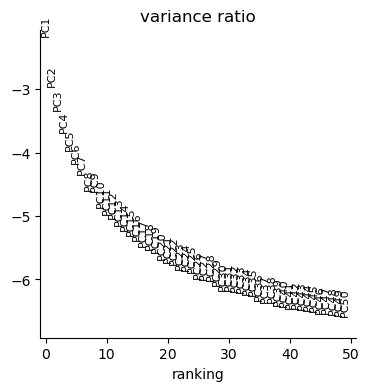

In [7]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50)

In [8]:
sc.pp.neighbors(adata, n_pcs=20)

In [9]:
sc.tl.umap(adata)

In [10]:
sc.tl.leiden(adata, resolution=0.75)

In [11]:
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos="paga", min_dist=1)

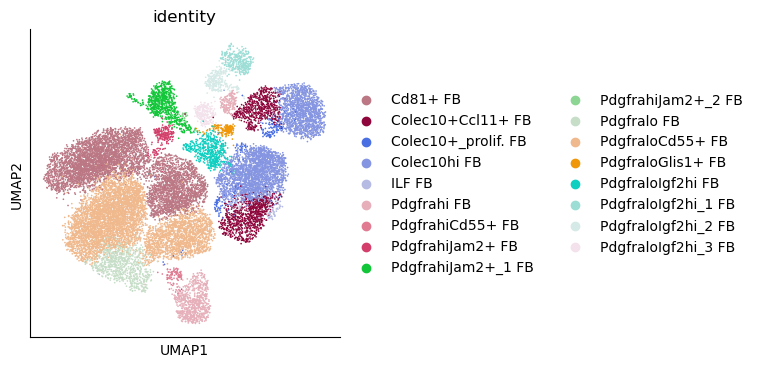

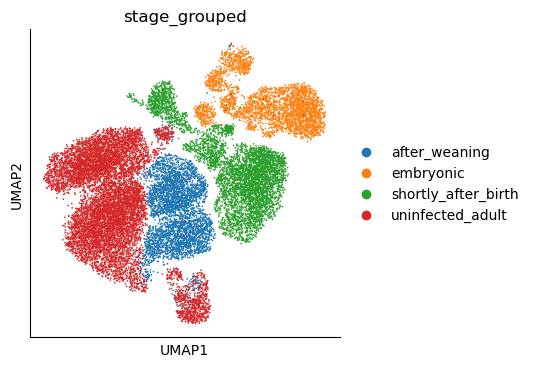

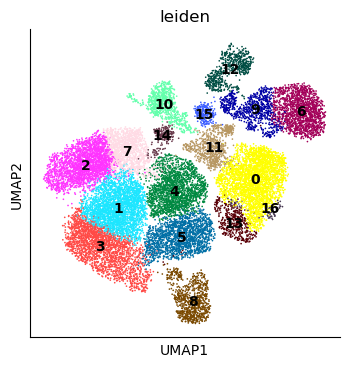

In [12]:
sc.pl.umap(adata, color = "identity", use_raw=False)
sc.pl.umap(adata, color = "stage_grouped", use_raw=False)
sc.pl.umap(adata, color = "leiden", use_raw=False, legend_loc="on data")

In [13]:
sc.tl.draw_graph(adata, layout="fa", init_pos="paga")

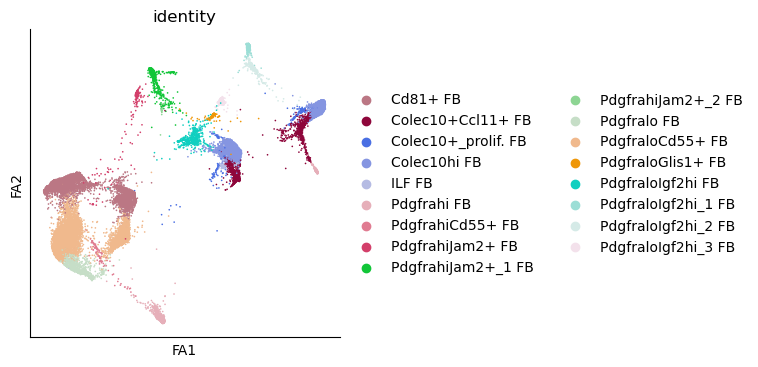

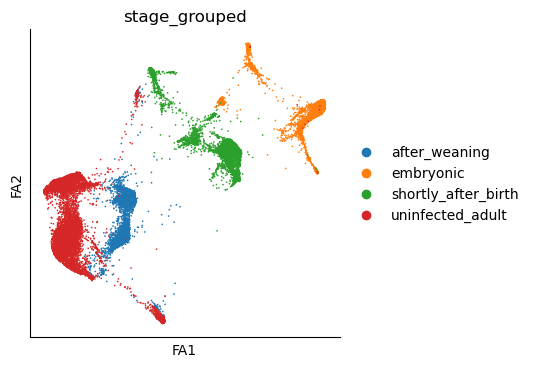

In [14]:
sc.pl.draw_graph(adata, color=['identity'])
sc.pl.draw_graph(adata, color=['stage_grouped'])

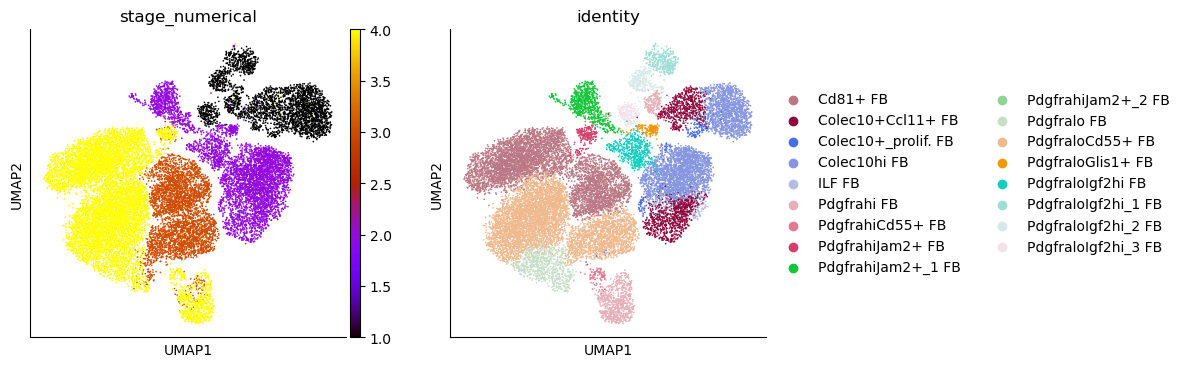

In [15]:
sc.pl.embedding(
    adata,
    basis="umap",
    color=["stage_numerical", "identity"],
    color_map="gnuplot",
)

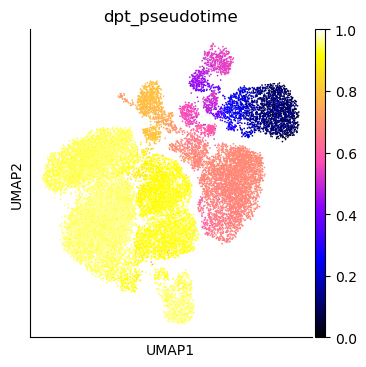

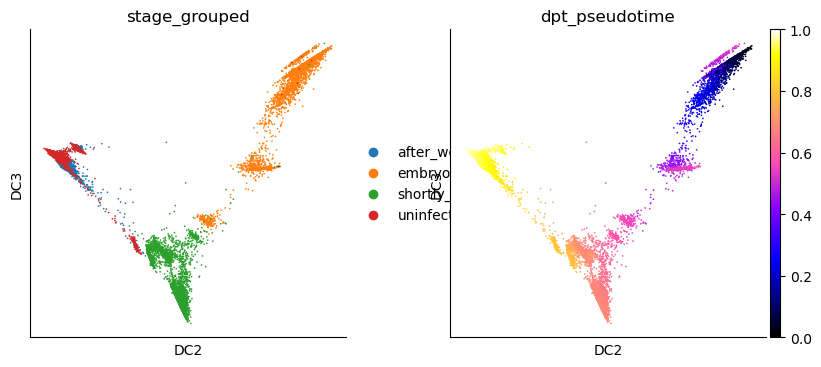

In [16]:
sc.tl.diffmap(adata)
adata.uns["iroot"] = adata.obsm['X_diffmap'][:, 1].argmax()
sc.tl.dpt(adata)
sc.pl.embedding(
    adata,
    basis="umap",
    color=["dpt_pseudotime"],
    color_map="gnuplot2",
)
sc.pl.embedding(
    adata,
    basis="diffmap",
    color=["stage_grouped", "dpt_pseudotime"],
    color_map="gnuplot2",
    components=["2,3"]
)

In [17]:
root_cell_index = adata.obsm['X_diffmap'][:, 1].argmax()

In [18]:
start_cell = adata.obs_names[root_cell_index]
start_cell

'ACTGTGAGTAACATCC-1_5'

In [19]:
# Run diffusion maps
dm_res = palantir.utils.run_diffusion_maps(adata, n_components=5)
ms_data = palantir.utils.determine_multiscale_space(adata)

(<Figure size 1500x300 with 5 Axes>,
 {0: <Axes: title={'center': 'Component 0'}>,
  1: <Axes: title={'center': 'Component 1'}>,
  2: <Axes: title={'center': 'Component 2'}>,
  3: <Axes: title={'center': 'Component 3'}>,
  4: <Axes: title={'center': 'Component 4'}>})

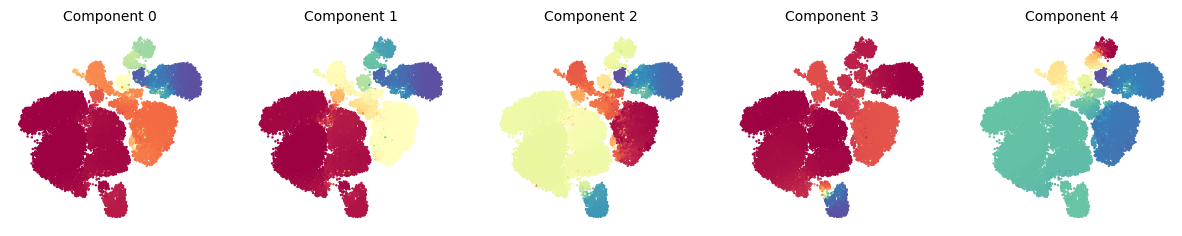

In [20]:
palantir.plot.plot_diffusion_components(adata)

In [21]:
# Function to sanitize the identity strings
def sanitize_identity(identity):
    # Remove spaces
    identity = identity.replace(" ", "")
    
    # Replace "+" with "pos" and "-" with "neg"
    identity = identity.replace("+", "pos").replace("-", "neg")
    
    return identity

# Apply the sanitize_identity function to create the new column
adata.obs["identity_simplified"] = adata.obs["identity"].apply(sanitize_identity)

# Create a new column in adata.obs that combines "identity_simplified" and "stage_grouped"
adata.obs["identity_simplified_stage"] = adata.obs["identity_simplified"].astype(str) + "_" + adata.obs["stage_grouped"].astype(str)

# Print the new column to verify the changes
print(adata.obs["identity_simplified"])

# Print the new column to verify the changes
print(adata.obs["identity_simplified_stage"])

CellName
AAACCCAAGTATCTGC-1_1    PdgfraloCd55posFB
AAACCCACATGACTGT-1_1            Cd81posFB
AAAGGATTCCAAACCA-1_1            Cd81posFB
AAAGGGCAGTCTACCA-1_1    PdgfraloCd55posFB
AAAGGTACACCACATA-1_1            Cd81posFB
                              ...        
TTTGTTGGTAGTGATA-1_8    PdgfraloCd55posFB
TTTGTTGTCACATCAG-1_8    PdgfraloCd55posFB
TTTGTTGTCAGGACGA-1_8    PdgfraloCd55posFB
TTTGTTGTCCCATAAG-1_8    PdgfraloCd55posFB
TTTGTTGTCTGGTGCG-1_8    PdgfraloCd55posFB
Name: identity_simplified, Length: 21000, dtype: category
Categories (17, object): ['Cd81posFB', 'Colec10posCcl11posFB', 'Colec10pos_prolif.FB', 'Colec10hiFB', ..., 'PdgfraloIgf2hiFB', 'PdgfraloIgf2hi_1FB', 'PdgfraloIgf2hi_2FB', 'PdgfraloIgf2hi_3FB']
CellName
AAACCCAAGTATCTGC-1_1    PdgfraloCd55posFB_uninfected_adult
AAACCCACATGACTGT-1_1            Cd81posFB_uninfected_adult
AAAGGATTCCAAACCA-1_1            Cd81posFB_uninfected_adult
AAAGGGCAGTCTACCA-1_1    PdgfraloCd55posFB_uninfected_adult
AAAGGTACACCACATA-1_1            C

In [44]:
# Assuming 'adata' is your AnnData object

# Filter cells in the "uninfected_adult" stage
uninfected_adult_cells = adata[adata.obs["stage_grouped"] == "uninfected_adult"]

# Get unique identities in the "uninfected_adult" stage
identities = uninfected_adult_cells.obs["identity"].unique()

# Initialize lists to store the terminal state cell names and identities
terminal_cell_names = []
terminal_identities = []

# Define the list of identities to exclude
exclude_identities = [
    "Colec10+Ccl11+ FB",
    "PdgfraloIgf2hi_2 FB",
    "PdgfraloIgf2hi FB",
    "Colec10hi FB",
    "PdgfraloIgf2hi_1 FB",
    "ILF FB"
]

# Iterate over each identity
for identity in identities:
    # Check if the current identity is not in the exclude list
    if identity not in exclude_identities:
        # Filter cells for the current identity
        identity_cells = uninfected_adult_cells[uninfected_adult_cells.obs["identity"] == identity]
        
        # Find the index of the cell with the smallest value in the 2nd diffusion component
        min_cell_index = identity_cells.obsm["X_diffmap"][:, 1].argmin()
        
        # Get the cell name corresponding to the minimum index
        min_cell_name = identity_cells.obs_names[min_cell_index]
        
        # Append the cell name and identity to the respective lists
        terminal_cell_names.append(min_cell_name)
        terminal_identities.append(identity)

# Create a pandas Series with cell names as the index and identities as the values
terminal_states = pd.Series(terminal_identities, index=terminal_cell_names)
terminal_states

CGGAATTGTCGCTTAA-1_8    PdgfraloCd55+ FB
GATGAGGCAAACACGG-1_8            Cd81+ FB
GACCTTCAGCCTATCA-1_8         Pdgfrahi FB
TCAGGGCCACCAGCGT-1_8         Pdgfralo FB
GTCTGTCCAGCGTTTA-1_8    PdgfrahiCd55+ FB
TGCGATACATCTTAGG-1_8    PdgfrahiJam2+ FB
dtype: object

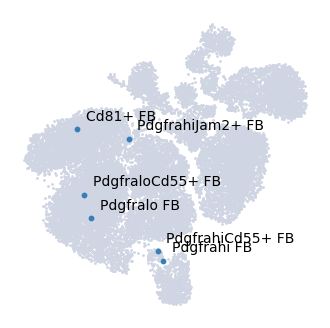

In [45]:
palantir.plot.highlight_cells_on_umap(adata, terminal_states)
plt.show()

In [46]:
pr_res = palantir.core.run_palantir(
    adata, start_cell, num_waypoints=500, terminal_states=terminal_states
)

Sampling and flocking waypoints...
Time for determining waypoints: 0.03609562317530314 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 2.341166853904724 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


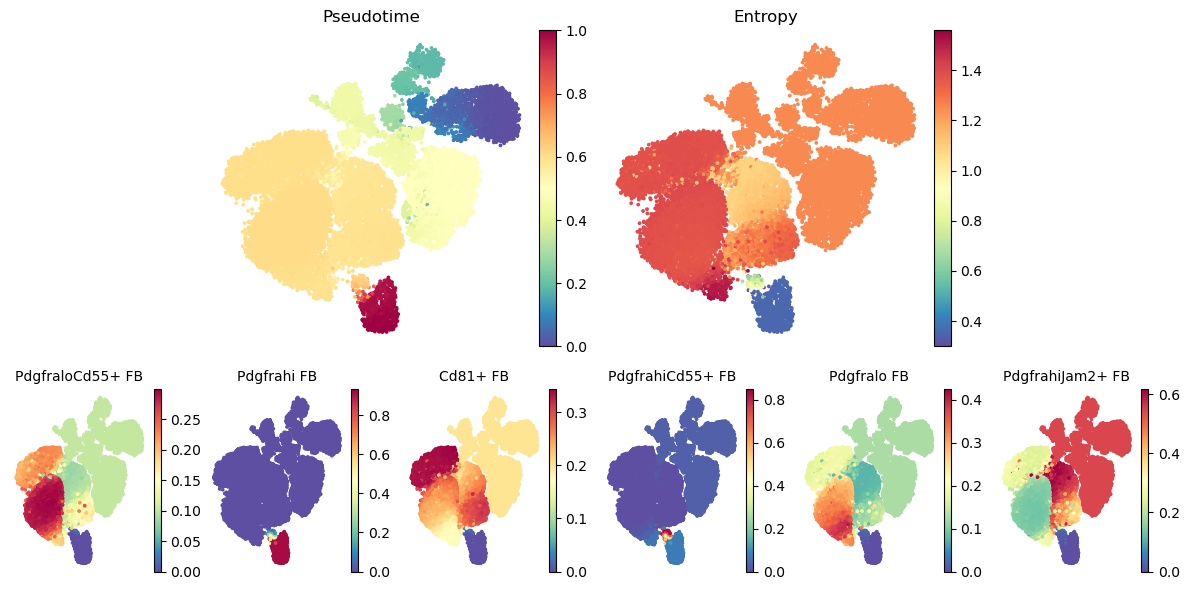

In [47]:
palantir.plot.plot_palantir_results(adata, s=3)
plt.show()

In [48]:
terminal_states

CGGAATTGTCGCTTAA-1_8    PdgfraloCd55+ FB
GATGAGGCAAACACGG-1_8            Cd81+ FB
GACCTTCAGCCTATCA-1_8         Pdgfrahi FB
TCAGGGCCACCAGCGT-1_8         Pdgfralo FB
GTCTGTCCAGCGTTTA-1_8    PdgfrahiCd55+ FB
TGCGATACATCTTAGG-1_8    PdgfrahiJam2+ FB
dtype: object

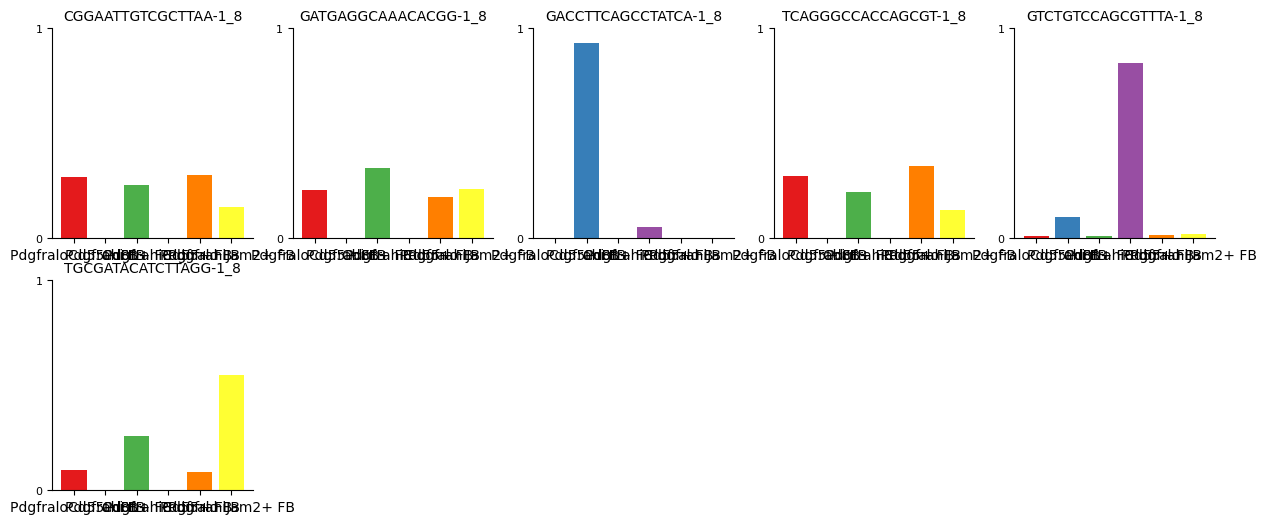

In [49]:
palantir.plot.plot_terminal_state_probs(adata, terminal_states.index)
plt.show()

In [69]:
masks = palantir.presults.select_branch_cells(adata, q=.0000001, eps=.0000001)

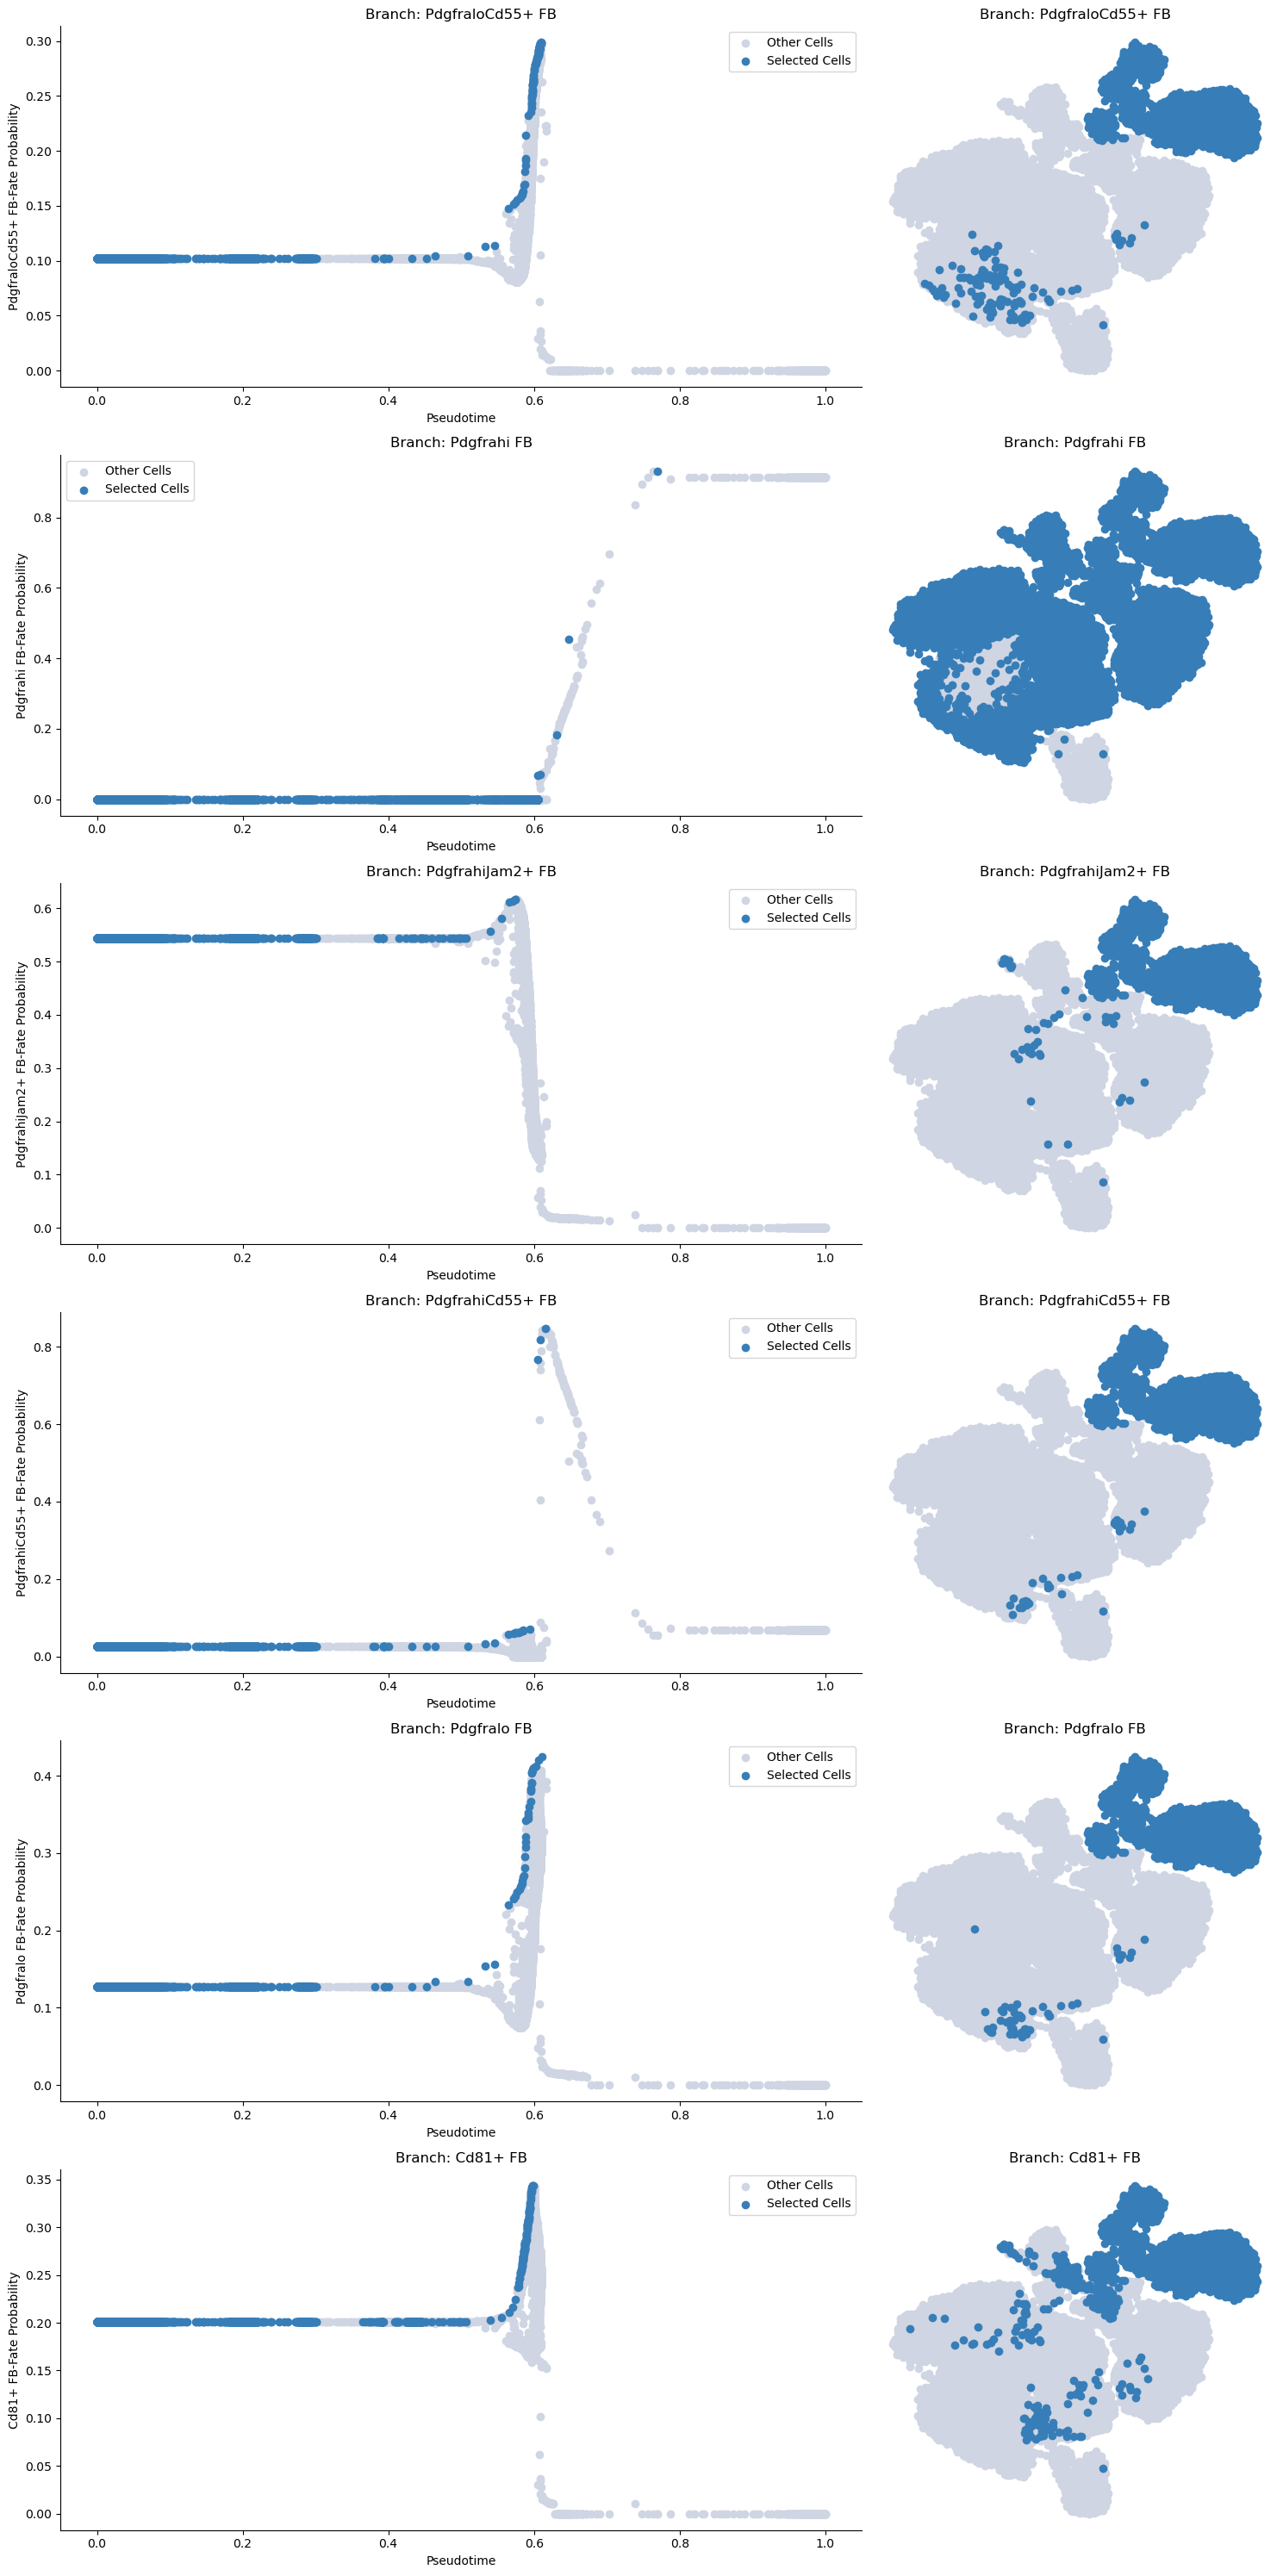

In [70]:
palantir.plot.plot_branch_selection(adata)
plt.show()

[2024-09-13 11:27:38,751] [INFO    ] Using sparse Gaussian Process since n_landmarks (50) < n_samples (3,436) and rank = 1.0.
[2024-09-13 11:27:38,753] [INFO    ] Using covariance function Matern52(ls=2.282298278808594).
[2024-09-13 11:27:38,784] [INFO    ] Computing 50 landmarks with k-means clustering.
[2024-09-13 11:27:39,605] [INFO    ] Using sparse Gaussian Process since n_landmarks (50) < n_samples (3,153) and rank = 1.0.
[2024-09-13 11:27:39,606] [INFO    ] Using covariance function Matern52(ls=2.282298278808594).
[2024-09-13 11:27:39,636] [INFO    ] Computing 50 landmarks with k-means clustering.
[2024-09-13 11:27:40,337] [INFO    ] Using sparse Gaussian Process since n_landmarks (50) < n_samples (3,135) and rank = 1.0.
[2024-09-13 11:27:40,338] [INFO    ] Using covariance function Matern52(ls=2.282298278808594).
[2024-09-13 11:27:40,368] [INFO    ] Computing 50 landmarks with k-means clustering.
[2024-09-13 11:27:41,080] [INFO    ] Using sparse Gaussian Process since n_landmar

<Axes: title={'center': 'Branch: PdgfraloCd55+ FB'}>

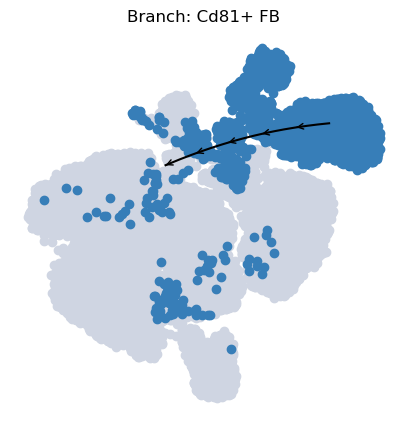

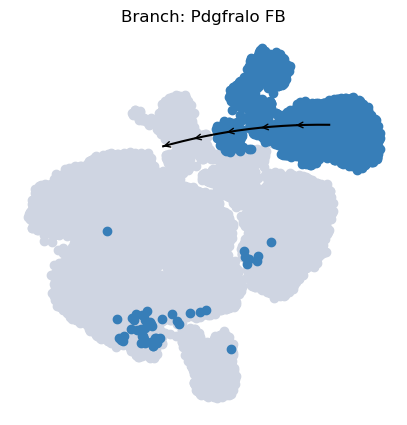

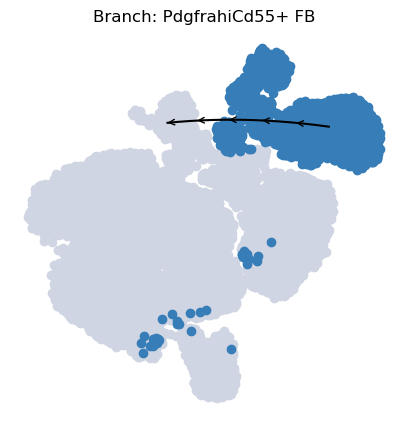

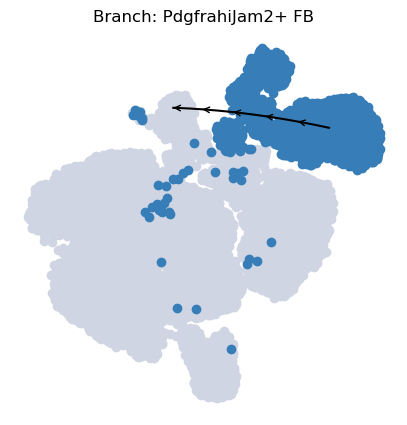

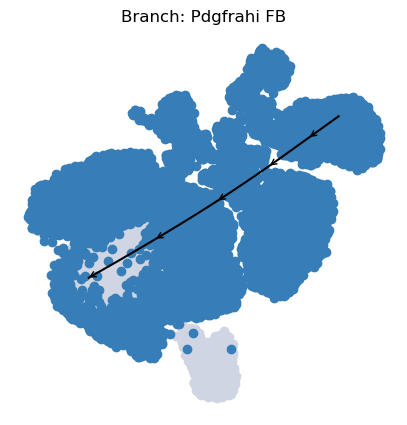

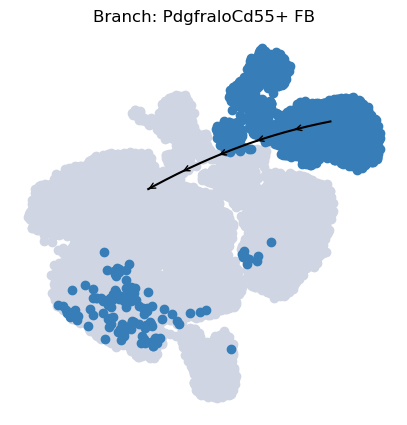

In [71]:
palantir.plot.plot_trajectory(adata, "Cd81+ FB")
palantir.plot.plot_trajectory(adata, "Pdgfralo FB")
palantir.plot.plot_trajectory(adata, "PdgfrahiCd55+ FB")
palantir.plot.plot_trajectory(adata, "PdgfrahiJam2+ FB")
palantir.plot.plot_trajectory(adata, "Pdgfrahi FB")
palantir.plot.plot_trajectory(adata, "PdgfraloCd55+ FB")

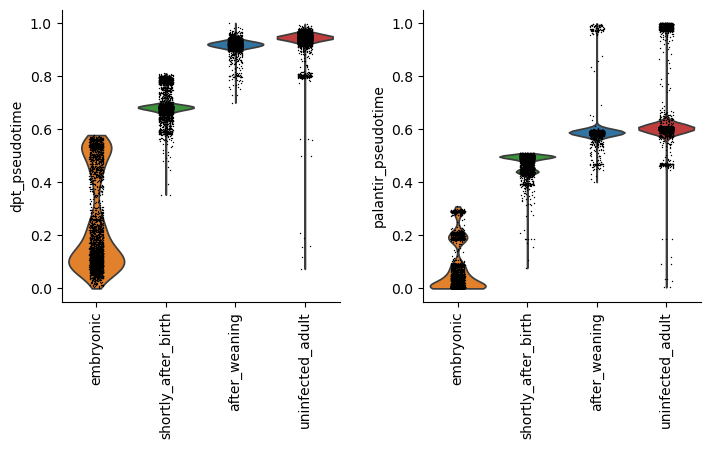

In [54]:
sc.pl.violin(
    adata,
    keys=["dpt_pseudotime", "palantir_pseudotime"],
    groupby="stage_grouped",
    rotation=90,
    order=["embryonic", "shortly_after_birth", "after_weaning", "uninfected_adult"]
)

100%|█████████████████████████████████| 21000/21000 [00:06<00:00, 3024.30cell/s]


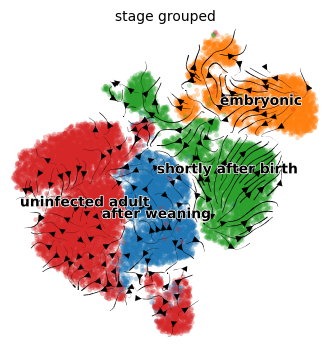

In [55]:
pk = cr.kernels.PseudotimeKernel(adata, time_key="dpt_pseudotime")
pk.compute_transition_matrix()

pk.plot_projection(basis="umap", recompute=True, color="stage_grouped")

100%|█████████████████████████████████| 21000/21000 [00:07<00:00, 2987.60cell/s]


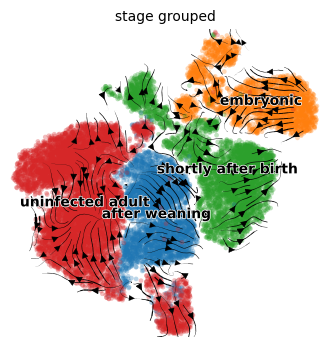

In [56]:
pk = cr.kernels.PseudotimeKernel(adata, time_key="palantir_pseudotime")
pk.compute_transition_matrix()

pk.plot_projection(basis="umap", recompute=True, color="stage_grouped")

In [57]:
tp = TemporalProblem(adata)

In [58]:
tp = tp.score_genes_for_marginals(
    gene_set_proliferation="mouse", gene_set_apoptosis="mouse"
)

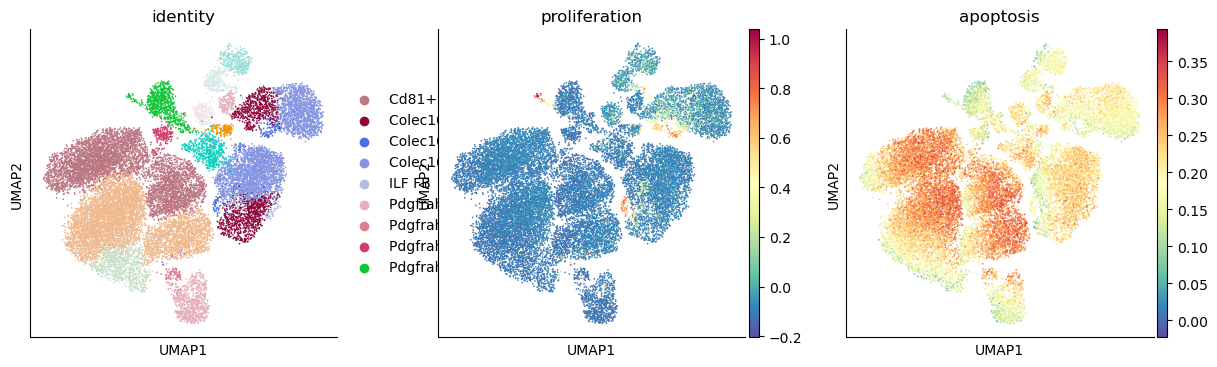

In [59]:
sc.pl.embedding(
    adata, basis="umap", color=["identity", "proliferation", "apoptosis"]
)

In [60]:
adata.obs['stage_numerical_categorical'] = pd.Categorical(adata.obs['stage_numerical'])
tp = tp.prepare(time_key="stage_numerical_categorical")

INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  


In [61]:
tp = tp.solve(epsilon=1e-3, tau_a=0.95, scale_cost="mean")

INFO     Solving `3` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(4850, 3845)].                                  
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(3084, 4850)].                                  
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(3845, 9221)].                                  


In [62]:
tmk = RealTimeKernel.from_moscot(tp)

In [63]:
tmk.compute_transition_matrix(self_transitions="all", conn_weight=0.2, threshold="auto")

100%|███████████████████████████████████| 3/3 [00:00<00:00, 24818.37time pair/s]


RealTimeKernel[n=21000, threshold='auto', self_transitions='all']

100%|████████████████████████████████████████| 100/100 [00:16<00:00,  6.09sim/s]


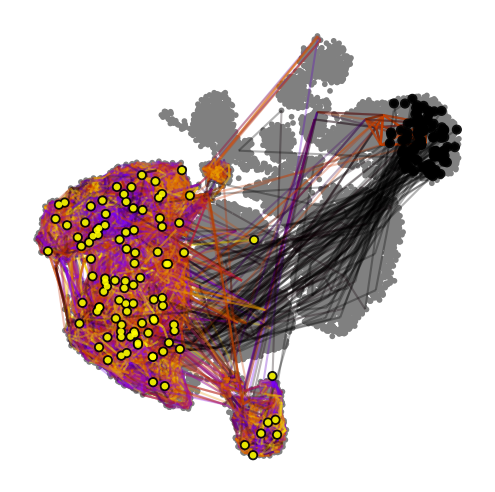

In [74]:
tmk.plot_random_walks(
    max_iter=500,
    start_ixs={'dpt_pseudotime': [0, 0.1]},
    basis="umap",
    seed=0,
    dpi=150,
    size=30,
)

In [75]:
g = cr.estimators.GPCCA(tmk)
print(g)

GPCCA[kernel=RealTimeKernel[n=21000], initial_states=None, terminal_states=None]


/home/ubuntu/anaconda3/envs/cellrankenv/lib/python3.11/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/home/ubuntu/anaconda3/envs/cellrankenv/lib/python3.11/site-packages/scvelo/plotting/scatter.py:694: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/ubuntu/anaconda3/envs/cellrankenv/lib/python3.11/site-packages/scvelo/plotting/utils.py:1391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=bg_size, marker=".", c=bg_color, zorder=zord - 2, **kwargs)
/home/ubuntu/anaconda3/envs/cellrankenv/lib/python3.11/site-packages/scvelo/plotting/utils.py:1392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=gp_size, marker=".", c=gp_color, zorder=zord - 1, **kwargs)


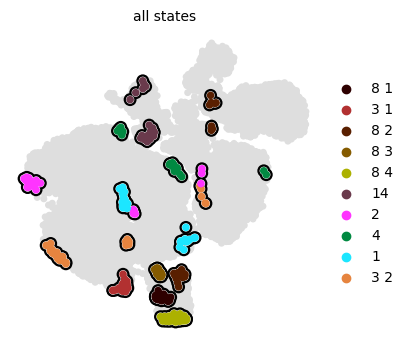

In [76]:
g.fit(cluster_key="leiden", n_states=[10,12], method='krylov')
g.plot_macrostates(which="all", discrete=True, legend_loc="right", s=100)

/home/ubuntu/anaconda3/envs/cellrankenv/lib/python3.11/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/home/ubuntu/anaconda3/envs/cellrankenv/lib/python3.11/site-packages/scvelo/plotting/scatter.py:694: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/ubuntu/anaconda3/envs/cellrankenv/lib/python3.11/site-packages/scvelo/plotting/utils.py:1391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=bg_size, marker=".", c=bg_color, zorder=zord - 2, **kwargs)
/home/ubuntu/anaconda3/envs/cellrankenv/lib/python3.11/site-packages/scvelo/plotting/utils.py:1392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=gp_size, marker=".", c=gp_color, zorder=zord - 1, **kwargs)


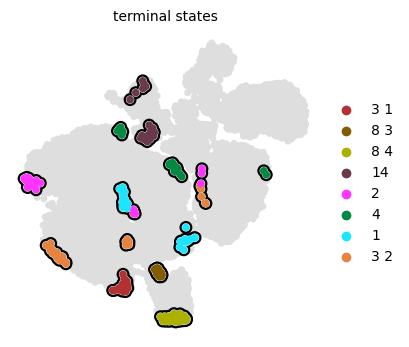

In [77]:
g.predict_terminal_states()
g.plot_macrostates(which="terminal", legend_loc="right", s=100)

/home/ubuntu/anaconda3/envs/cellrankenv/lib/python3.11/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/home/ubuntu/anaconda3/envs/cellrankenv/lib/python3.11/site-packages/scvelo/plotting/scatter.py:694: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/ubuntu/anaconda3/envs/cellrankenv/lib/python3.11/site-packages/scvelo/plotting/utils.py:1391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=bg_size, marker=".", c=bg_color, zorder=zord - 2, **kwargs)
/home/ubuntu/anaconda3/envs/cellrankenv/lib/python3.11/site-packages/scvelo/plotting/utils.py:1392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=gp_size, marker=".", c=gp_color, zorder=zord - 1, **kwargs)


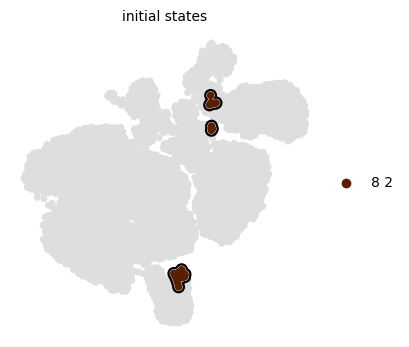

In [78]:
g.predict_initial_states()
g.plot_macrostates(which="initial", legend_loc="right", s=100)